In [2]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

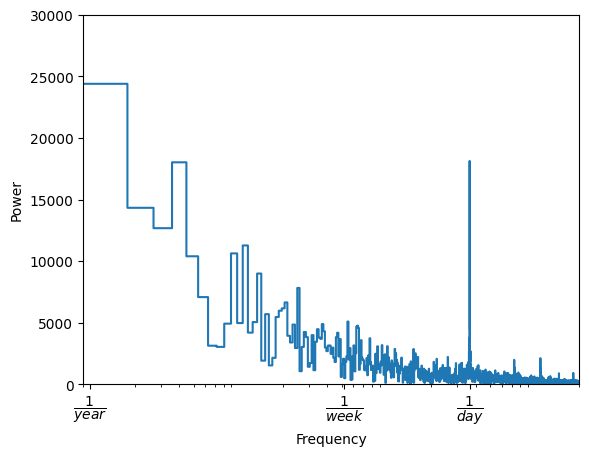

In [4]:
fft = np.fft.rfft(sensor_data['2LivingRoomCenter_temperature'])
f_per_dataset = np.arange(0, len(fft))

measurements_per_hour = 60/15
n_samples_h = len(sensor_data['2LivingRoomCenter_temperature'])/measurements_per_hour
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

# plt.rcParams['text.usetex'] = True
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 30000)
plt.xlim([0.9, 2000])
plt.xticks([1, 52.177, 365.2524], labels=[r'$\dfrac{1}{year}$', r'$\dfrac{1}{week}$', r'$\dfrac{1}{day}$'])
_ = plt.xlabel('Frequency')
_ = plt.ylabel('Power')
plt.savefig('./drawings/periodogram.pdf', bbox_inches = "tight")


In [5]:
data = sensor_data.copy()
data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)
data = data.drop(data.columns[data.columns.str.endswith('door')], axis=1)
data = data.drop(["2LivingRoomCenter_humidity_temperature", "1MainBR_hum_temperature", "2LivingRoom_humidifier_temperature"], axis=1)

In [6]:
data.columns

Index(['0BRoom_temperature', '0BTCeiling_temperature', '0BTFloor_temperature',
       '1Entrance1_temperature', '1GuestRoom_temperature',
       '1MainRoom_temperature', '1OutdoorEntrance_temperature',
       '1StairBottom_temperature', '2BalconyEntrance_temperature',
       '2Cooking_temperature', '2Fireplace_temperature',
       '2LRWindow_temperature', '2LivingRoomCenter_temperature',
       '2OfficeDesk_temperature', '2Stair_temperature'],
      dtype='object')

In [7]:
cols = ["0fBedroom", "0fLivingRoomCeiling", '0fLivingRoomFloor',
        "1fEntranceHall1", "1fBedroom1", "1fBedroom2",
        "Outdoor", "1fStair", "2fBalconyEntrance", "2fKitchen", 
        "2fFireplace", "2fLivingRoomWindow", 
        "2fLivingRoomCenter", "2fOffice", "2fStair"]

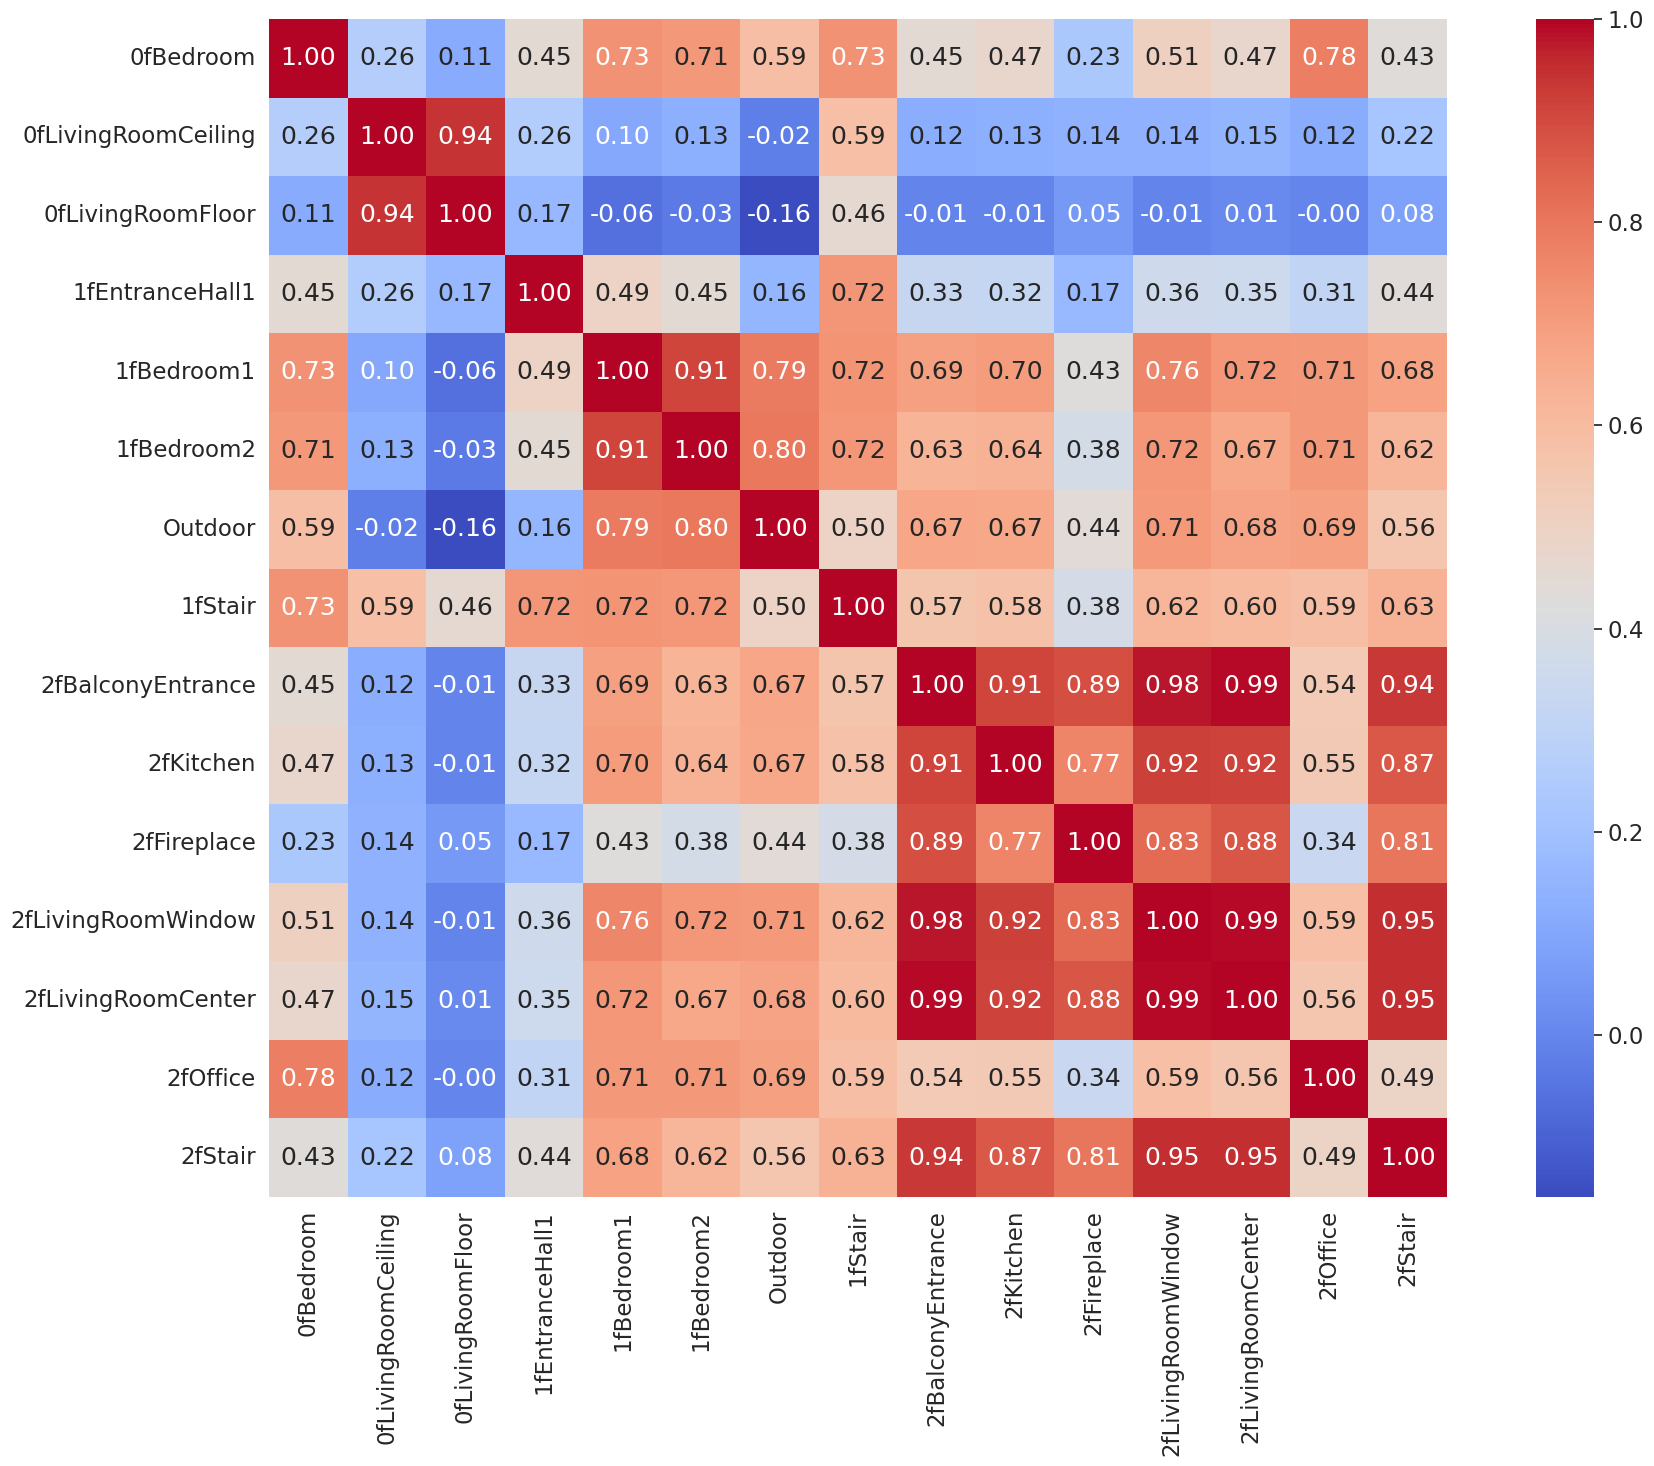

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
# cols = data.columns
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(data.values)
cov_mat =np.corrcoef(X_std.T)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 18},
                 cmap='coolwarm',               
                 yticklabels=cols,
                 xticklabels=cols)
plt.tight_layout()
plt.savefig('./drawings/covariance.pdf', bbox_inches = "tight")
plt.show()

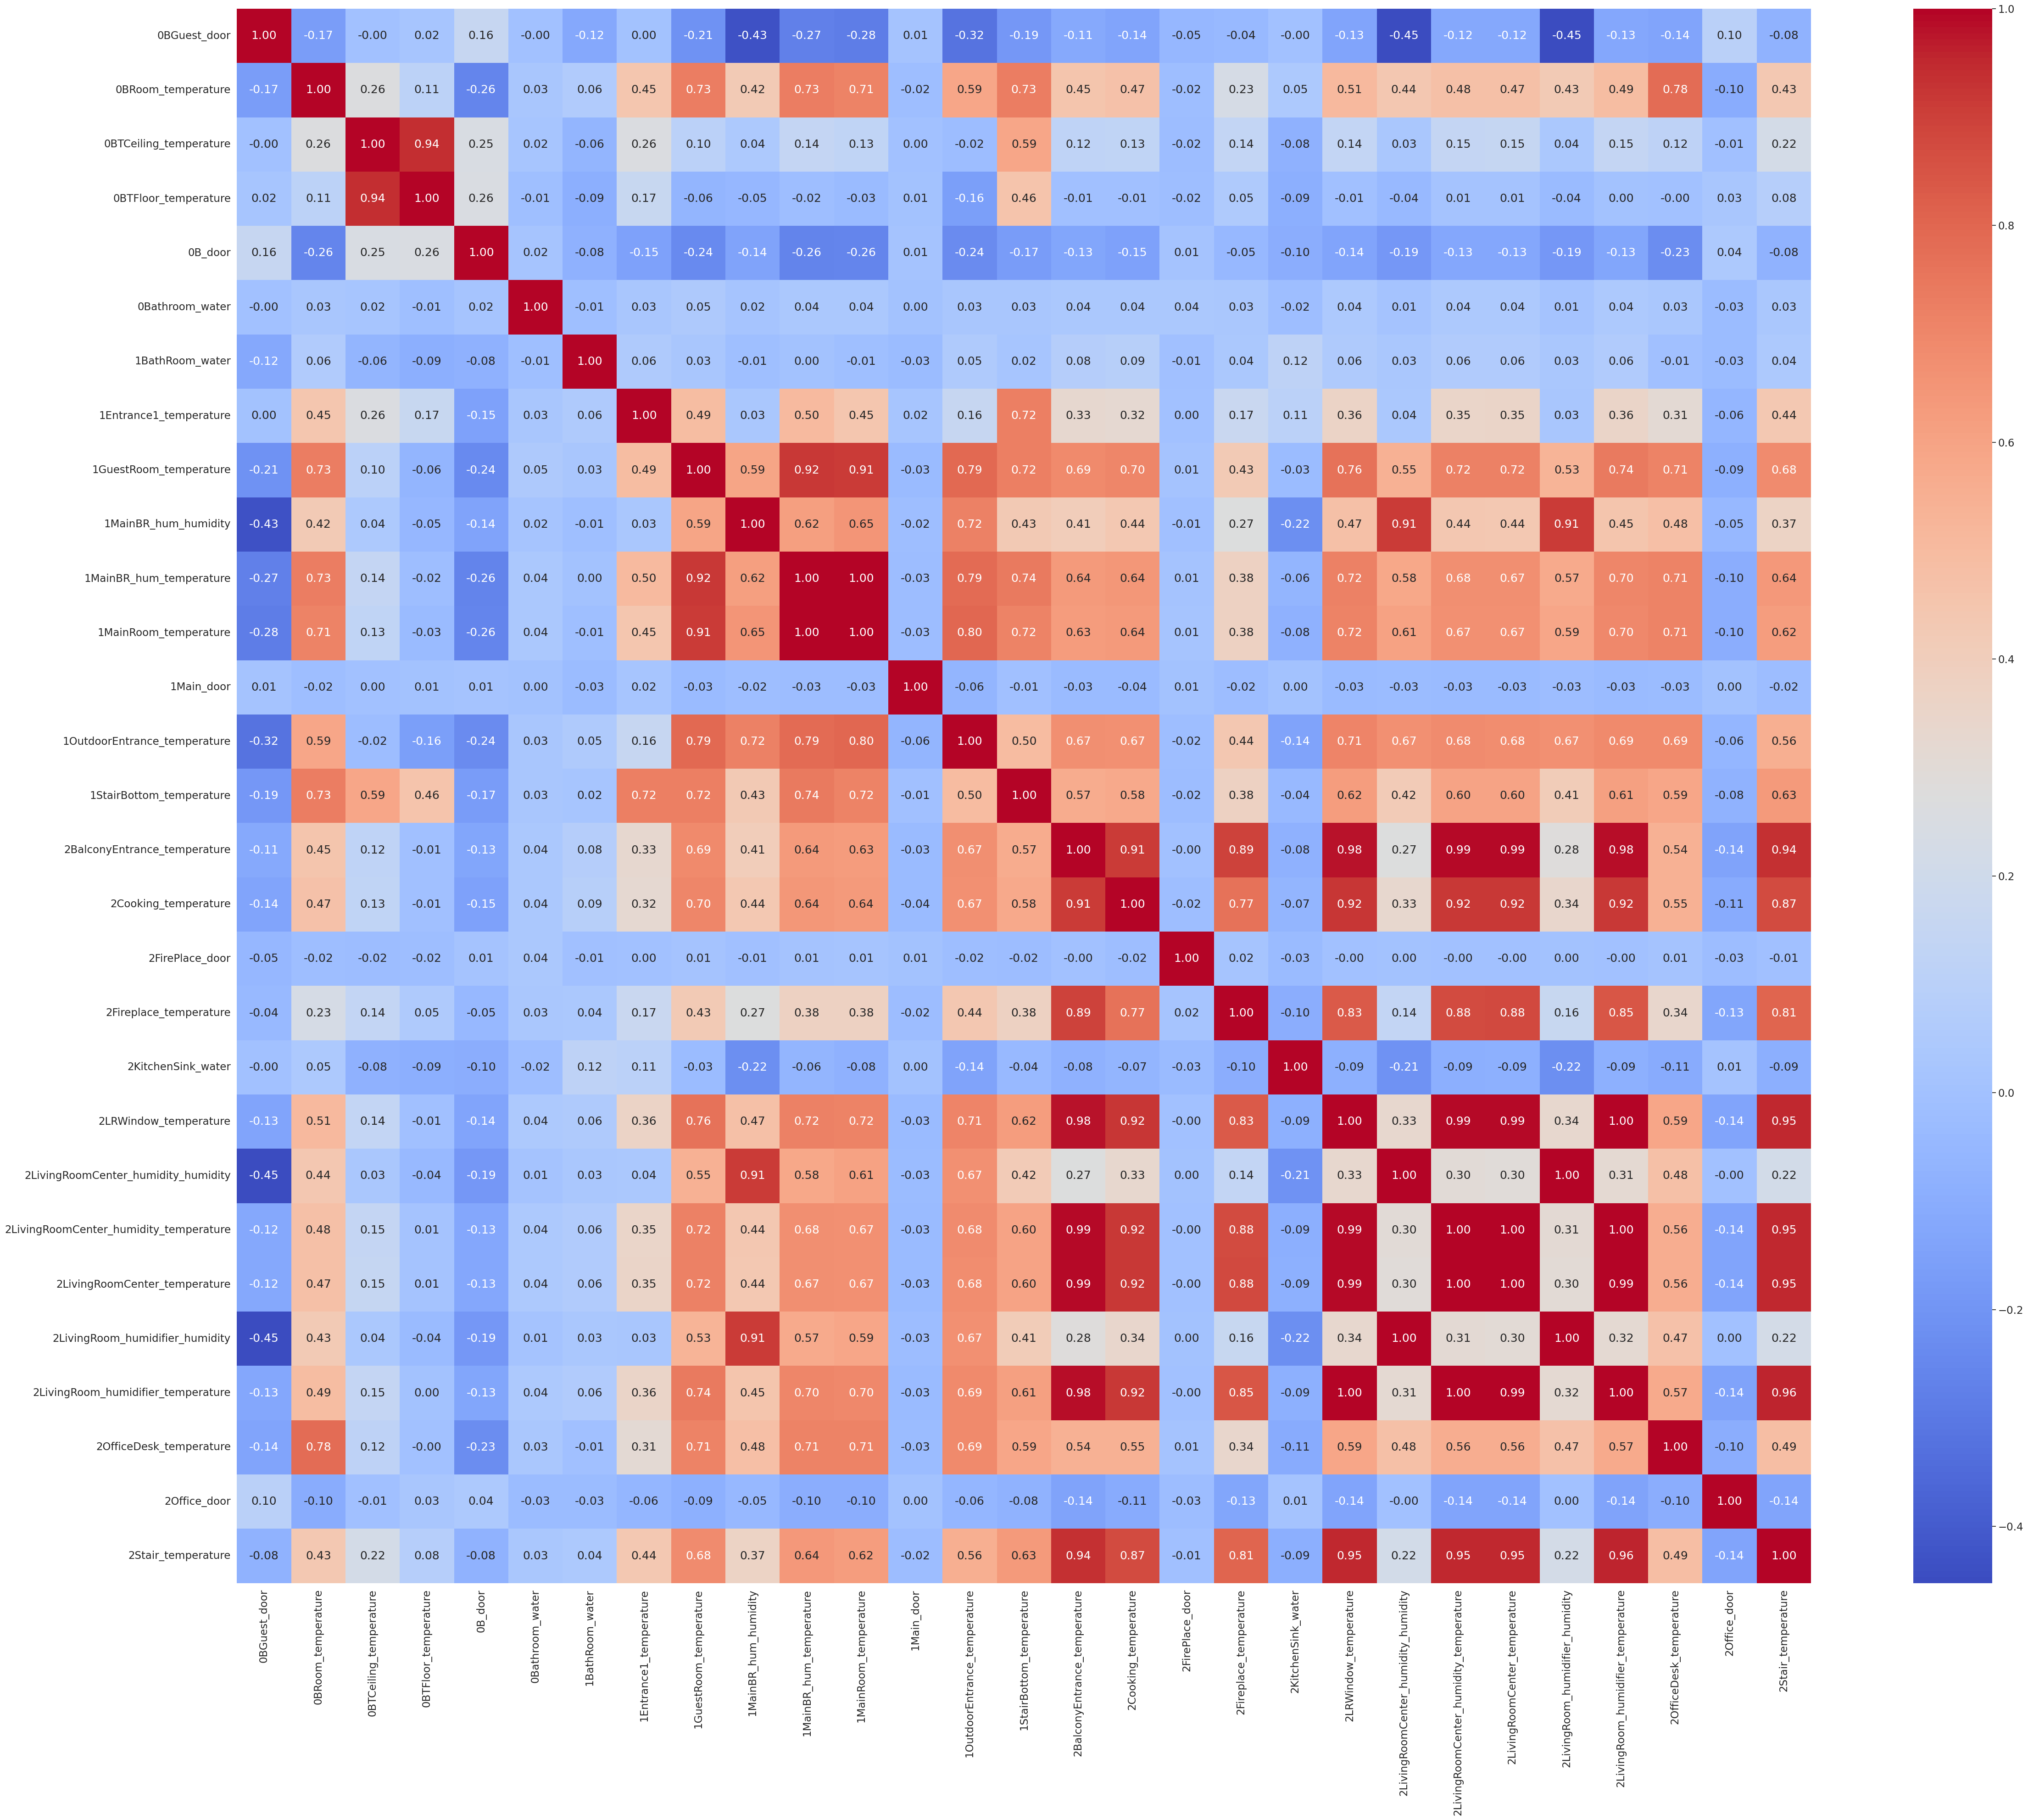

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
cols = sensor_data.columns
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(sensor_data.values)
cov_mat =np.corrcoef(sensor_data.values.T)
plt.figure(figsize=(50,40))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 18},
                 cmap='coolwarm',               
                 yticklabels=cols,
                 xticklabels=cols)
plt.tight_layout()
plt.savefig('./drawings/all_covariance.pdf', bbox_inches = "tight")
plt.show()

In [10]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values


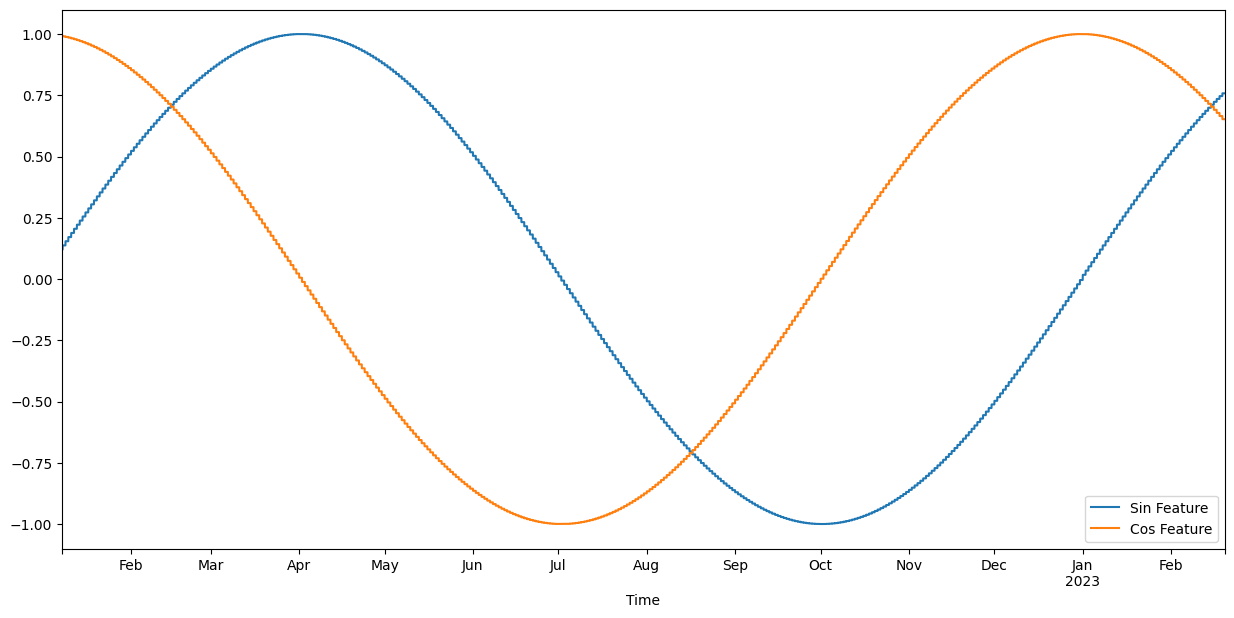

In [22]:
plt.style.use("default")
ax = sensor_data['sin_yearly'].plot(figsize=(15,7), label='Sin Feature')
sensor_data['cos_yearly'].plot(label='Cos Feature')
ax.legend(loc='lower right')
ax.set_xlabel('Time')
ax.minorticks_off()
ax.figure.savefig('./drawings/sin_cos_yearly.pdf', bbox_inches = "tight")

In [201]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature', "2Stair_temperature"] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

# data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
# data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [202]:
temp_indices = data.columns[data.columns.str.endswith('temperature')]

train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_1_dot = train_df_1.copy()
train_df_1_dot.loc[:, temp_indices] = train_df_1.loc[:, temp_indices].diff().shift(-1).dropna()
train_df_1_dot = train_df_1_dot[:-1]
train_df_1 = train_df_1[:-1]
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df_2_dot = train_df_2.copy()
train_df_2_dot.loc[:, temp_indices] = train_df_2[temp_indices].diff().shift(-1).dropna()
train_df_2_dot = train_df_2_dot[:-1]
train_df_2 = train_df_2[:-1]
train_df = pd.concat([train_df_1, train_df_2])
train_df_dot = pd.concat([train_df_1_dot, train_df_2_dot])
labels = data.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1).columns

val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
val_df_dot = val_df.copy()
val_df_dot.loc[:, temp_indices] = val_df[temp_indices].diff().shift(-1).dropna()
val_df_dot = val_df_dot[:-1]
val_df = val_df[:-1]

test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()
test_df_dot = test_df.copy()
test_df_dot.loc[:, temp_indices] = test_df[temp_indices].diff().shift(-1).dropna()
test_df_dot = test_df_dot[:-1]
test_df = test_df[:-1]

x_scaler = StandardScaler()
x_scaler.fit(pd.concat([train_df_dot, val_df_dot]))

train_df_1_dot_scaled = x_scaler.transform(train_df_1_dot)
train_df_2_dot_scaled = x_scaler.transform(train_df_2_dot)
train_df_1_dot_scaled = pd.DataFrame(train_df_1_dot_scaled, columns=train_df.columns)
train_df_2_dot_scaled = pd.DataFrame(train_df_2_dot_scaled, columns=train_df.columns)
val_df_dot_scaled = x_scaler.transform(val_df_dot)
val_df_dot_scaled = pd.DataFrame(val_df_dot_scaled, columns=val_df.columns)
test_df_dot_scaled = x_scaler.transform(test_df_dot)
test_df_dot_scaled = pd.DataFrame(test_df_dot_scaled, columns=test_df.columns)

y_scaler = StandardScaler()
y_scaler.fit(pd.concat([train_df_dot[labels], val_df_dot[labels]]))


print(f"Shape of train_df = {pd.concat([train_df_1_dot_scaled,train_df_2_dot_scaled]).shape}, Shape of val_df = {val_df_dot_scaled.shape}, Shape of test_df = {test_df_dot_scaled.shape}")
print(f"Shape of train_labels = {labels.shape}, Shape of val_labels = {labels.shape}, Shape of test_labels = {labels.shape}")

Shape of train_df = (33212, 22), Shape of val_df = (2975, 22), Shape of test_df = (2975, 22)
Shape of train_labels = (10,), Shape of val_labels = (10,), Shape of test_labels = (10,)


In [240]:
data.columns = pd.Index(["0fBedroomDoor", "0fBedroom", "0fLivingRoom", '0fLivingRoomDoor',
                         "1EntranceHall", "1fBedroom1", "1fBedroom2", "1fEntranceDoor",
                         "Outdoor", "1fStair", "2fKitchen", "2fFireplaceDoor",
                         "2fFireplace", "2fLivingRoomCenter", "2fOffice", "2fOfficeDoor",
                         "CosDaily", "CosWeekly", "CosYearly", "SinDaily", "SinWeekly", "SinYearly"])

norm_data.columns = pd.Index(["0fBedroomDoor", "0fBedroom", "0fLivingRoom", '0fLivingRoomDoor',
                         "1EntranceHall", "1fBedroom1", "1fBedroom2", "1fEntranceDoor",
                         "Outdoor", "1fStair", "2fKitchen", "2fFireplaceDoor",
                         "2fFireplace", "2fLivingRoomCenter", "2fOffice", "2fOfficeDoor",
                         "CosDaily", "CosWeekly", "CosYearly", "SinDaily", "SinWeekly", "SinYearly"])

In [237]:
norm_data = pd.concat([test_df_dot, val_df_dot, pd.concat([train_df_1_dot,train_df_2_dot])])

In [229]:
data.columns = pd.Index(["0fBedroomDoor", "0fBedroom", "0fLivingRoom", '0fLivingRoomDoor',
                         "1EntranceHall", "1fBedroom1", "1fBedroom2", "1fEntranceDoor",
                         "Outdoor", "1fStair", "2fKitchen", "2fFireplaceDoor",
                         "2fFireplace", "2fLivingRoomCenter", "2fOffice", "2fOfficeDoor",
                         "CosDaily", "CosWeekly", "CosYearly", "SinDaily", "SinWeekly", "SinYearly"])

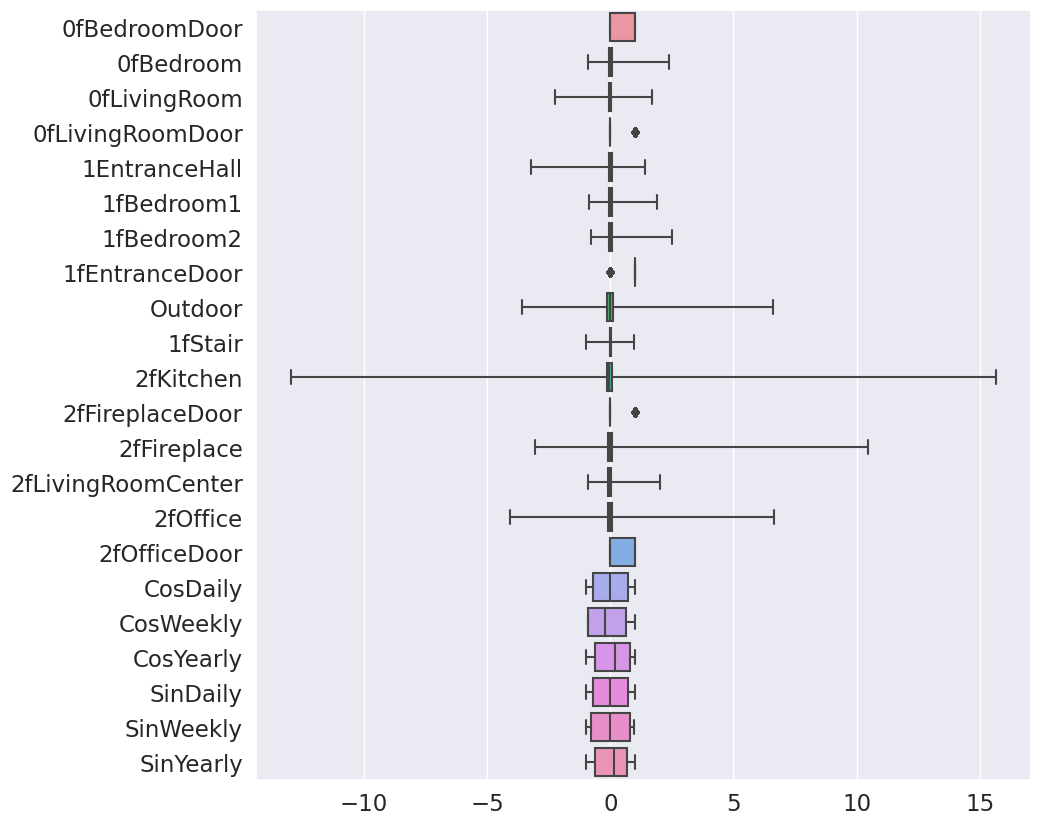

In [241]:
outdoor_temp_columns = data.columns.str.endswith('OutdoorEntrance_temperature')
indoor_temp_columns = data.columns.str.endswith('temperature') #& np.logical_not(outdoor_temp_columns)
ax = sns.boxplot(norm_data.loc[:, :], showfliers=True, orient='h', whis=10000)
ax.figure.set_size_inches(10, 10)
ax.figure.savefig('./drawings/boxplot_normalized.pdf', bbox_inches = "tight")

In [249]:
print(norm_data["2fKitchen"])

timestamp
2022-07-01 00:00:00+00:00   -0.05
2022-07-01 00:15:00+00:00   -0.05
2022-07-01 00:30:00+00:00   -0.10
2022-07-01 00:45:00+00:00   -0.05
2022-07-01 01:00:00+00:00   -0.05
                             ... 
2023-02-19 17:45:00+00:00   -0.15
2023-02-19 18:00:00+00:00   -0.30
2023-02-19 18:15:00+00:00    0.00
2023-02-19 18:30:00+00:00   -0.50
2023-02-19 18:45:00+00:00   -0.10
Name: 2fKitchen, Length: 39162, dtype: float64
